## From Nick Weir
https://github.com/nrweir/NW_insight_cv_tutorial/blob/master/computer_vision_tutorial.ipynb

In [10]:
import numpy as np
from cv2 import cv2
from scipy import ndimage as ndi
from scipy import signal
from skimage import io
from skimage import feature
import skimage
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [11]:
tutorial_dir  = 'Data/'
microscopy_file = 'microscopy.tif'
doggo_file = 'doggo.jpg'
microscopy = io.imread(tutorial_dir + microscopy_file)
doggo = io.imread(tutorial_dir + doggo_file)

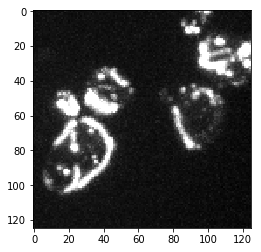

In [12]:
plt.imshow(microscopy, cmap='gray')

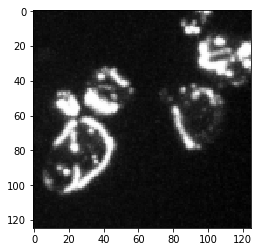

In [13]:
microscopy = ndi.gaussian_filter(microscopy, sigma=(0.5,0.5))
plt.imshow(microscopy, cmap='gray')

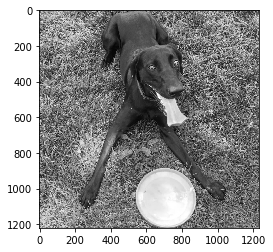

In [14]:
gray_doggo = cv2.cvtColor(doggo, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_doggo, cmap='gray')

## Segmentation
## Part 1: Thresholding

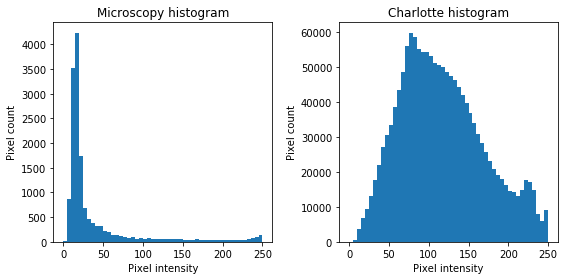

In [17]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
# need to flatten arrays for generating 1D histograms
plt.hist(microscopy.flatten(), bins=np.arange(0,255,5))
plt.title('Microscopy histogram')
plt.xlabel('Pixel intensity')
plt.ylabel('Pixel count')
plt.subplot(1,2,2)
plt.ylabel('Pixel count')
plt.hist(gray_doggo.flatten(), bins=np.arange(0,255,5))
plt.xlabel('Pixel intensity')
plt.title('Charlotte histogram')
plt.tight_layout()

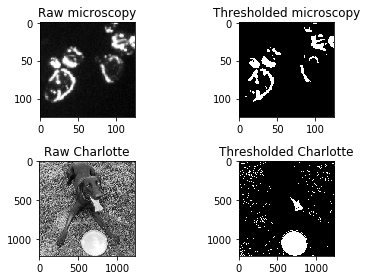

In [18]:
microscopy_threshold = 150
charlotte_threshold = 200
plt.subplot(2,2,1)
plt.imshow(microscopy, cmap='gray')
plt.title('Raw microscopy')
plt.subplot(2,2,2)
plt.imshow(microscopy > microscopy_threshold, cmap='gray')
plt.title('Thresholded microscopy')
plt.subplot(2,2,3)
plt.imshow(gray_doggo, cmap='gray')
plt.title('Raw Charlotte')
plt.subplot(2,2,4)
plt.imshow(gray_doggo > charlotte_threshold, cmap='gray')
plt.title('Thresholded Charlotte')
plt.tight_layout()

Text(0.5,1,'Thresholded smoothed Charlotte')

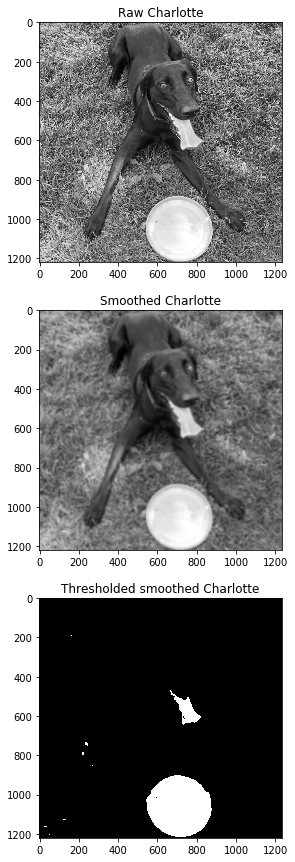

In [19]:
smooth_doggo = ndi.gaussian_filter(gray_doggo, sigma=(4,4))
plt.figure(figsize=(5,15))
plt.subplot(3,1,1)
plt.imshow(gray_doggo, cmap='gray')
plt.title('Raw Charlotte')
plt.subplot(3,1,2)
plt.imshow(smooth_doggo, cmap='gray')
plt.title('Smoothed Charlotte')
plt.subplot(3,1,3)
plt.imshow(smooth_doggo > charlotte_threshold, cmap='gray')
plt.title('Thresholded smoothed Charlotte')

## Part 2: Edge detection

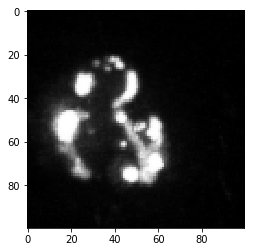

In [21]:
microscopy_2 = io.imread(tutorial_dir + 'microscopy_2.tif')
microscopy_2 = ndi.gaussian_filter(microscopy_2, sigma=(0.5,0.5))
plt.imshow(microscopy_2, cmap='gray')

Text(0.5,1,'High cutoff, misses dim dots')

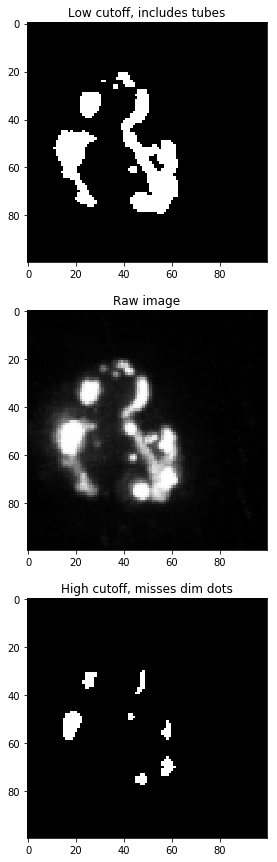

In [22]:
figure = plt.figure(figsize=(5,15))
plt.subplot(3,1,1)
plt.imshow(microscopy_2 > 100, cmap='gray')
plt.title('Low cutoff, includes tubes')
plt.subplot(3,1,2)
plt.imshow(microscopy_2, cmap='gray')
plt.title('Raw image')
plt.subplot(3,1,3)
plt.imshow(microscopy_2 > 250, cmap='gray')
plt.title('High cutoff, misses dim dots')

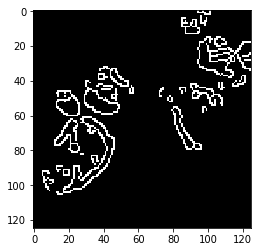

In [23]:
canny_microscopy = cv2.Canny(microscopy, 100,200)
plt.imshow(canny_microscopy, cmap='gray')

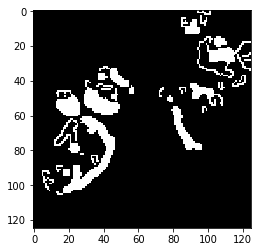

In [24]:
filled_microscopy = ndi.binary_fill_holes(canny_microscopy)
plt.imshow(filled_microscopy, cmap='gray')

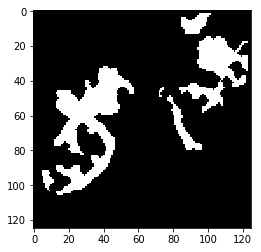

In [25]:
# create structuring element for binary closing
s = ndi.morphology.generate_binary_structure(2,1)
strel = np.zeros((5,5))
strel[2,2] = 1
strel = ndi.binary_dilation(strel, s, iterations=2)
# perform closing
canny_microscopy = ndi.binary_closing(canny_microscopy, structure=strel)
# fill holes
filled_microscopy = ndi.binary_fill_holes(canny_microscopy)
plt.imshow(filled_microscopy, cmap='gray')

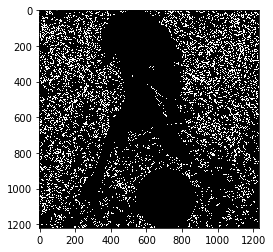

In [27]:
doggo_edges = cv2.Canny(gray_doggo, 150,600)
plt.imshow(doggo_edges, cmap='gray')

##  Watershed segmentation

Text(0.5,1,'Thresholded image')

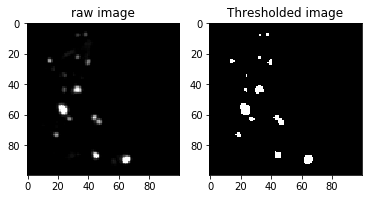

In [28]:
# object ID from microscopy data
raw_im = io.imread(tutorial_dir + 'microscopy_3.tif')
thresholded_im = raw_im > 50
figure = plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(raw_im, cmap='gray')
plt.title('raw image')
plt.subplot(1,2,2)
plt.imshow(thresholded_im, cmap='gray')
plt.title('Thresholded image')

Text(0.5,1,'Distance-transformed peroxisomes')

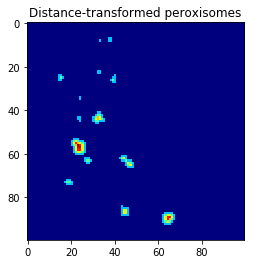

In [29]:
# Euclidean distance transform
dist_xform = ndi.morphology.distance_transform_edt(thresholded_im)
plt.imshow(dist_xform, cmap='jet')
plt.title('Distance-transformed peroxisomes')

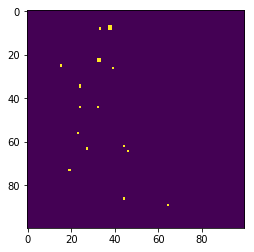

In [30]:
smooth_dist = ndi.gaussian_filter(dist_xform, sigma=(0.5,0.5))

# the following modified from here: https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array
neighborhood = ndi.generate_binary_structure(2,2)

#apply the local maximum filter; all pixel of maximal value 
#in their neighborhood are set to 1
local_max = ndi.maximum_filter(smooth_dist, footprint=neighborhood)==smooth_dist
#local_max is a mask that contains the peaks we are 
#looking for, but also the background.
#In order to isolate the peaks we must remove the background from the mask.

#we create the mask of the background
background = (thresholded_im==0)

#a little technicality: we must erode the background in order to 
#successfully subtract it form local_max, otherwise a line will 
#appear along the background border (artifact of the local maximum filter)
eroded_background = ndi.binary_erosion(background, structure=neighborhood, iterations=3, border_value=1)

#we obtain the final mask, containing only peaks, 
#by removing the background from the local_max mask (xor operation)
maxima = local_max ^ eroded_background

plt.imshow(maxima)

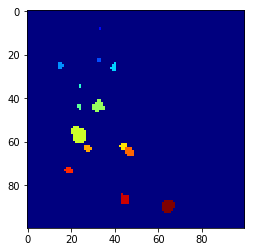

In [33]:
from skimage.measure import label
from skimage.morphology import watershed
labels = label(maxima, connectivity=1) # individually label each seed point with a different numeric ID
labels[labels == 1] = 0  # remove background labels
labeled_pexs = watershed(-smooth_dist, labels, mask=thresholded_im)
plt.imshow(labeled_pexs, cmap='jet')

Feature detection algorithms
SIFT, SURF, ORB, and other feature detection algorithms are implemented in OpenCV, a fantastic computer vision library for python. Some of these algorithms are proprietary and shouldn't be used for commercial purposes without a license.

For the theory behind these algorithms, see here:

SIFT
SURF
ORB

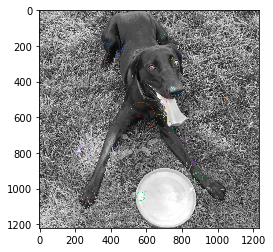

In [35]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=50)
kp = sift.detect(smooth_doggo,None)  # we need to use the smoothed version because the sharpness makes too many edges.
img = cv2.drawKeypoints(gray_doggo,kp,gray_doggo, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)